In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import poisson
import scipy.special

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [2]:
import autograd.numpy as ag_np
import autograd.scipy.stats as ag_stats

# Goal: Find reseanable prior duration distribution from infected(I) to symptomatic(M) stage (Delta Variant)

According to the d and f boxplot in figure 3 from artile Transmission, viral kinetics and clinical characteristics of the emergent SARS-CoV-2 Delta VOC in Guangzhou, China, we knwo the incubation period is 4(2-6) days from infected to mildly symptomatic.  

Article link: https://www.sciencedirect.com/science/article/pii/S2589537021004090

### Generic function to assess how well samples from a proposed distribution fit our criteria

In [3]:
def pprint_samples(samps_v1_S, samps_v2_S):
    pd.set_option('display.precision', 3)
    row_dict_list = list()
    for perc, desired in [(25, 2),(50, 4), (75, 6)]:
        observed1 = np.percentile(samps_v1_S, perc)
        observed2 = np.percentile(samps_v2_S, perc)
        row_dict_list.append(dict(perc=perc, desired=desired, observed1=observed1, observed2=observed2))
    df = pd.DataFrame(row_dict_list)
    print(df)    

In [4]:
def samples_mean(samps_v1_S, samps_v2_S):
    desiredmean = 4.3
    observed1 = np.mean(samps_v1_S)
    observed2 = np.mean(samps_v2_S)
    df = pd.DataFrame({'desiredmean': [desiredmean], 'observed1': [observed1], 'observed2': [observed2]})
    print(df)

## Let's look at the one parameter poisson(4.3) distribution

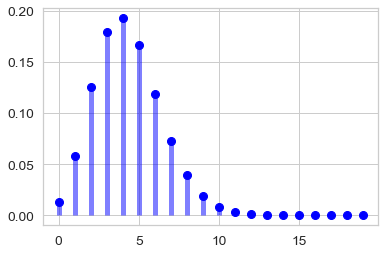

In [5]:
fig, ax = plt.subplots(1, 1)

mu = 4.3
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
x = np.arange(0,20)
ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

In [6]:
S = 10000

In [7]:
def sample_from_1param(lam, size=100000, J=20, random_state=0):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam)
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom

    if isinstance(random_state, int):
        prng = np.random.RandomState(random_state)
    else:
        prng = random_state
    return prng.choice(np.arange(1, J), p=pmf_J, size=size)

In [8]:
samps_v1_S = sample_from_1param(mu, size=S, random_state=1)
samps_v2_S = sample_from_1param(mu, size=S, random_state=2)

In [9]:
pprint_samples(samps_v1_S, samps_v2_S)

   perc  desired  observed1  observed2
0    25        2        3.0        3.0
1    50        4        4.0        4.0
2    75        6        6.0        6.0


In [10]:
samples_mean(samps_v1_S, samps_v2_S)

   desiredmean  observed1  observed2
0          4.3      4.343      4.322


## Let's find the best 2-parameter duration distribution that fits our constraints

In [11]:
def calc_2param_loss(lam, nu, J=20, day_p25=2, day_p50=4, day_p75=6):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam) / nu
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom
    cdf_J = ag_np.cumsum(pmf_J)
    
    error_at_p24 = 0.25 * np.square(0.24 - cdf_J[day_p25-1])
    error_at_p50 = 0.5 * np.square( 0.5 - cdf_J[day_p50-1])
    error_at_p75 = 0.25 * np.square(0.75 - cdf_J[day_p75-1])

    return error_at_p24 + error_at_p50 + error_at_p75 

In [12]:
G = 101
H = 99
lam_G = np.linspace(1, 12, G);
nu_H = np.logspace( np.log10(0.05), np.log10(50), H);

nu_GH, lam_GH = np.meshgrid(nu_H, lam_G);
assert nu_GH.shape == (G,H)

In [13]:
cost_GH = np.zeros((G,H))
for gg in range(G):
    for hh in range(H):
        cost_GH[gg,hh] = calc_2param_loss(lam_GH[gg,hh], nu_GH[gg,hh]);

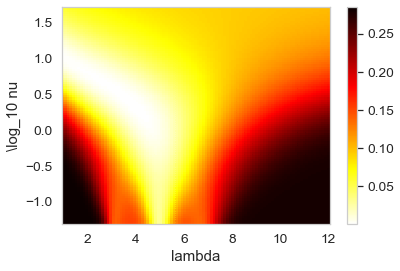

In [14]:
plt.pcolor(lam_GH, np.log10(nu_GH), cost_GH, shading='nearest', cmap='hot_r');
plt.colorbar();
plt.xlabel('lambda');
plt.ylabel('\log_10 nu');
plt.savefig('duration loss I to M.png')

In [15]:
minrow, mincol = np.unravel_index(np.argmin(cost_GH, axis=None), cost_GH.shape)
cost_GH[minrow, mincol]

0.00011372540198298019

In [16]:
bestlam = lam_GH[minrow, mincol]
bestnu = nu_GH[minrow, mincol]

In [17]:
bestlam, bestnu

(3.86, 2.413478718838935)

## Check the distribution achieves

In [18]:
def sample_from_2param(lam, nu, size=100000, J=35, random_state=0):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam) / nu
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom

    if isinstance(random_state, int):
        prng = np.random.RandomState(random_state)
    else:
        prng = random_state
    return prng.choice(np.arange(1, J), p=pmf_J, size=size)

In [19]:
samps_2param_v1_S = sample_from_2param(bestlam, bestnu, size=S, random_state=1)
samps_2param_v2_S = sample_from_2param(bestlam, bestnu, size=S, random_state=2)

In [20]:
print("2 param COST: %.7f" % (cost_GH[minrow, mincol]))

2 param COST: 0.0001137


In [21]:
pprint_samples(samps_2param_v1_S, samps_2param_v2_S)

   perc  desired  observed1  observed2
0    25        2        3.0        3.0
1    50        4        4.0        4.0
2    75        6        7.0        7.0


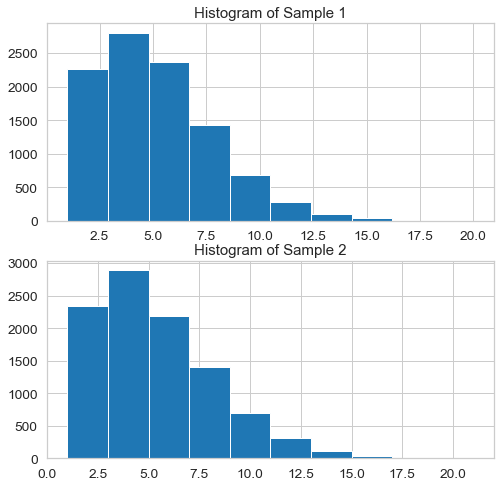

In [22]:
fig, axs = plt.subplots(2, figsize=(8,8))
axs[0].hist(samps_2param_v1_S)
axs[0].set_title('Histogram of Sample 1')
axs[1].hist(samps_2param_v2_S)
axs[1].set_title('Histogram of Sample 2')
plt.savefig('hist1.png')

In [23]:
samples_mean(samps_2param_v1_S, samps_2param_v2_S)

   desiredmean  observed1  observed2
0          4.3      4.881      4.858


# Now we need a PRIOR on lambda and nu, not just a point estimate

In [24]:
def sample_from_normal_truncated_to_positives(m, s, S=10000, random_state=0):
    return scipy.stats.truncnorm(
        (0-m)/s, np.inf, m, s).rvs(size=S, random_state=random_state)

In [25]:
prior_lam_mean = bestlam
prior_lam_std  = 1.00
prior_nu_mean = bestnu
prior_nu_std  = 0.05
S = 10000
R = 10

prng = np.random.RandomState(101)

lam_S = sample_from_normal_truncated_to_positives(prior_lam_mean, prior_lam_std, S, prng)
nu_S = sample_from_normal_truncated_to_positives(prior_nu_mean, prior_nu_std, S, prng)

all_samps = list()
for ss in range(S):
    samps_R = sample_from_2param(lam_S[ss], nu_S[ss], size=R, random_state=prng)
    all_samps.append(samps_R)
samps_A = np.hstack(all_samps)

In [26]:
pprint_samples(samps_A, samps_A)

   perc  desired  observed1  observed2
0    25        2        3.0        3.0
1    50        4        4.0        4.0
2    75        6        7.0        7.0


In [27]:
samples_mean(samps_A, samps_A)

   desiredmean  observed1  observed2
0          4.3      4.927      4.927


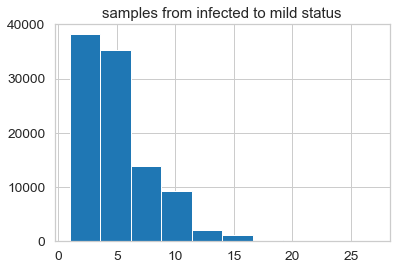

In [28]:
plt.hist(samps_A)
plt.title('samples from infected to mild status')
plt.savefig('figs/pi_M.png')

# Goal: Find reseanable prior duration distribution from symptomatic(M) to hospitalization(H) stage

According to the d and f boxplot in figure 3 from artile Transmission, viral kinetics and clinical characteristics of the emergent SARS-CoV-2 Delta VOC in Guangzhou, China, we knwo the incubation period is 7(5-10) days from mildly symptomatic to hospitalization(critical).  

In [29]:
def pprint_samples(samps_v1_S, samps_v2_S):
    pd.set_option('display.precision', 3)
    row_dict_list = list()
    for perc, desired in [(25, 5), (50, 7), (75, 10)]:
        observed1 = np.percentile(samps_v1_S, perc)
        observed2 = np.percentile(samps_v2_S, perc)
        row_dict_list.append(dict(perc=perc, desired=desired, observed1=observed1, observed2=observed2))
    df = pd.DataFrame(row_dict_list)
    print(df)

In [30]:
def calc_2param_loss(lam, nu, J=20, day_p25=4, day_p50=7, day_p75=8):
    logpmf_J = ag_stats.poisson.logpmf(np.arange(1, J), lam) / nu
    pmf_J = ag_np.exp(logpmf_J)
    denom = ag_np.sum(pmf_J)
    pmf_J = pmf_J / denom
    cdf_J = ag_np.cumsum(pmf_J)
    
    error_at_p25 = 0.30 * np.square(0.25 - cdf_J[day_p25-1])
    error_at_p50 = 0.50 * np.square(0.5 - cdf_J[day_p50-1])
    error_at_p75 = 0.20 * np.square(0.75 - cdf_J[day_p75-1])

    return error_at_p25 + error_at_p50 + error_at_p75

In [31]:
cost_GH = np.zeros((G,H))
for gg in range(G):
    for hh in range(H):
        cost_GH[gg,hh] = calc_2param_loss(lam_GH[gg,hh], nu_GH[gg,hh]);

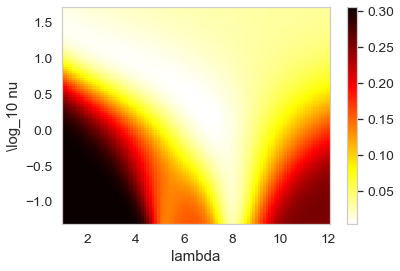

In [32]:
plt.pcolor(lam_GH, np.log10(nu_GH), cost_GH, shading='nearest', cmap='hot_r');
plt.colorbar();
plt.xlabel('lambda');
plt.ylabel('\log_10 nu');
plt.savefig('duration loss M to H.png')

In [33]:
minrow, mincol = np.unravel_index(np.argmin(cost_GH, axis=None), cost_GH.shape)
cost_GH[minrow, mincol]

0.003387183283072114

In [34]:
bestlam = lam_GH[minrow, mincol]
bestnu = nu_GH[minrow, mincol]

In [35]:
bestlam, bestnu

(6.83, 1.9534699685273083)

## Check the distribution achieves

In [36]:
samps_2param_v1_S = sample_from_2param(bestlam, bestnu, size=S, random_state=1)
samps_2param_v2_S = sample_from_2param(bestlam, bestnu, size=S, random_state=2)

In [37]:
print("2 param COST: %.7f" % (cost_GH[minrow, mincol]))

2 param COST: 0.0033872


In [38]:
pprint_samples(samps_2param_v1_S, samps_2param_v2_S)

   perc  desired  observed1  observed2
0    25        5        5.0        5.0
1    50        7        7.0        7.0
2    75       10       10.0       10.0


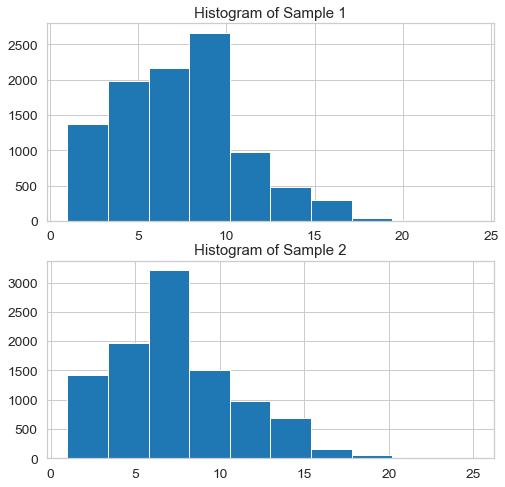

In [39]:
fig, axs = plt.subplots(2, figsize=(8,8))
axs[0].hist(samps_2param_v1_S)
axs[0].set_title('Histogram of Sample 1')
axs[1].hist(samps_2param_v2_S)
axs[1].set_title('Histogram of Sample 2')
plt.savefig('figs/hist2.png')

In [40]:
prior_lam_mean = bestlam
prior_lam_std  = 1.00
prior_nu_mean = bestnu
prior_nu_std  = 0.05
S = 10000
R = 10

prng = np.random.RandomState(101)

lam_S = sample_from_normal_truncated_to_positives(prior_lam_mean, prior_lam_std, S, prng)
nu_S = sample_from_normal_truncated_to_positives(prior_nu_mean, prior_nu_std, S, prng)

all_samps = list()
for ss in range(S):
    samps_R = sample_from_2param(lam_S[ss], nu_S[ss], size=R, random_state=prng)
    all_samps.append(samps_R)
samps_A = np.hstack(all_samps)

In [41]:
pprint_samples(samps_A, samps_A)

   perc  desired  observed1  observed2
0    25        5        5.0        5.0
1    50        7        7.0        7.0
2    75       10       10.0       10.0


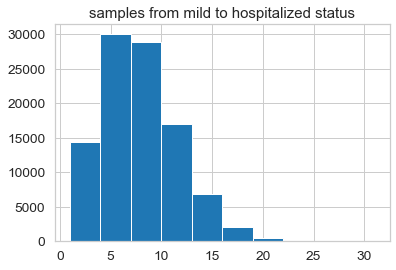

In [42]:
plt.hist(samps_A)
plt.title('samples from mild to hospitalized status')
plt.savefig('figs/pi_H.png')